# End-to-End Pipeline

<br>

### Imports

In [1]:
import xarray as xr

from satip import eumetsat, reproj, io

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import os
import dotenv

<br>

### User Inputs

In [15]:
data_dir = '../data/raw'
sorted_dir = '../data/sorted'
debug_fp = '../logs/EUMETSAT_download.txt'
env_vars_fp = '../.env'
metadata_db_fp = '../data/EUMETSAT_metadata.db'
new_grid_fp='../data/intermediate/new_grid_4km_TM.json'
new_coords_fp = '../data/intermediate/reproj_coords_TM_4km.csv'
out_zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/full_extent_TM_zarr_int16'

<br>

### Loading Environment Variables

In [3]:
dotenv.load_dotenv(env_vars_fp)

user_key = os.environ.get('USER_KEY')
user_secret = os.environ.get('USER_SECRET')
slack_id = os.environ.get('SLACK_ID')
slack_webhook_url = os.environ.get('SLACK_WEBHOOK_URL')

In [4]:
dm = eumetsat.DownloadManager(user_key, user_secret, data_dir, metadata_db_fp, debug_fp)

start_date = '2019-01-01 12:00'
end_date = '2019-01-01 12:05'

dm.download_datasets(start_date, end_date)

2020-11-30 23:34:40,689 - INFO - ********** Download Manager Initialised **************
2020-11-30 23:34:41,182 - INFO - 1 files queried, 0 found in ../data/raw, 1 to download.


 [████████████████████████████████████████████████████████████] 1/1 [00:09<00:09, 9.29s/it]

In [5]:
df_metadata = dm.get_df_metadata()

df_metadata.head()

start_date                end_date             result_time  \
id                                                                           
1  2020-10-01 12:05:09.428 2020-10-01 12:09:15.775 2020-10-01 12:09:15.775   
2  2020-10-01 12:10:09.249 2020-10-01 12:14:15.596 2020-10-01 12:14:15.596   
3  2020-10-01 12:15:09.071 2020-10-01 12:19:15.417 2020-10-01 12:19:15.417   
4  2020-10-01 12:20:08.892 2020-10-01 12:24:15.239 2020-10-01 12:24:15.239   
5  2020-10-01 12:25:08.714 2020-10-01 12:29:15.060 2020-10-01 12:29:15.060   

   platform_short_name platform_orbit_type instrument_name sensor_op_mode  \
id                                                                          
1                 MSG3                 GEO          SEVIRI            RSS   
2                 MSG3                 GEO          SEVIRI            RSS   
3                 MSG3                 GEO          SEVIRI            RSS   
4                 MSG3                 GEO          SEVIRI            RSS   
5                 MSG3                 GEO          SEVIRI            RSS   

   center_srs_name center_position  \
id                                   
1        EPSG:4326           0 9.5   
2        EPSG:4326           0 9.5   
3        EPSG:4326           0 9.5   
4        EPSG:4326           0 9.5   
5        EPSG:4326           0 9.5   

                                            file_name  file_size  missing_pct  \
id                                                                              
1   MSG3-SEVI-MSG15-0100-NA-20201001120915.7750000...      99819          0.0   
2   MSG3-SEVI-MSG15-0100-NA-20201001121415.5960000...      99819          0.0   
3   MSG3-SEVI-MSG15-0100-NA-20201001121915.4170000...      99819          0.0   
4   MSG3-SEVI-MSG15-0100-NA-20201001122415.2390000...      99819          0.0   
5   MSG3-SEVI-MSG15-0100-NA-20201001122915.0600000...      99819          0.0   

                   downloaded  
id                             
1  2020-11-13 10:32:40.853958  
2  2020-11-13 10:32:56.874131  
3  2020-11-13 10:33:13.998136  
4  2020-11-13 10:33:30.656217  
5  2020-11-13 10:33:46.352754

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


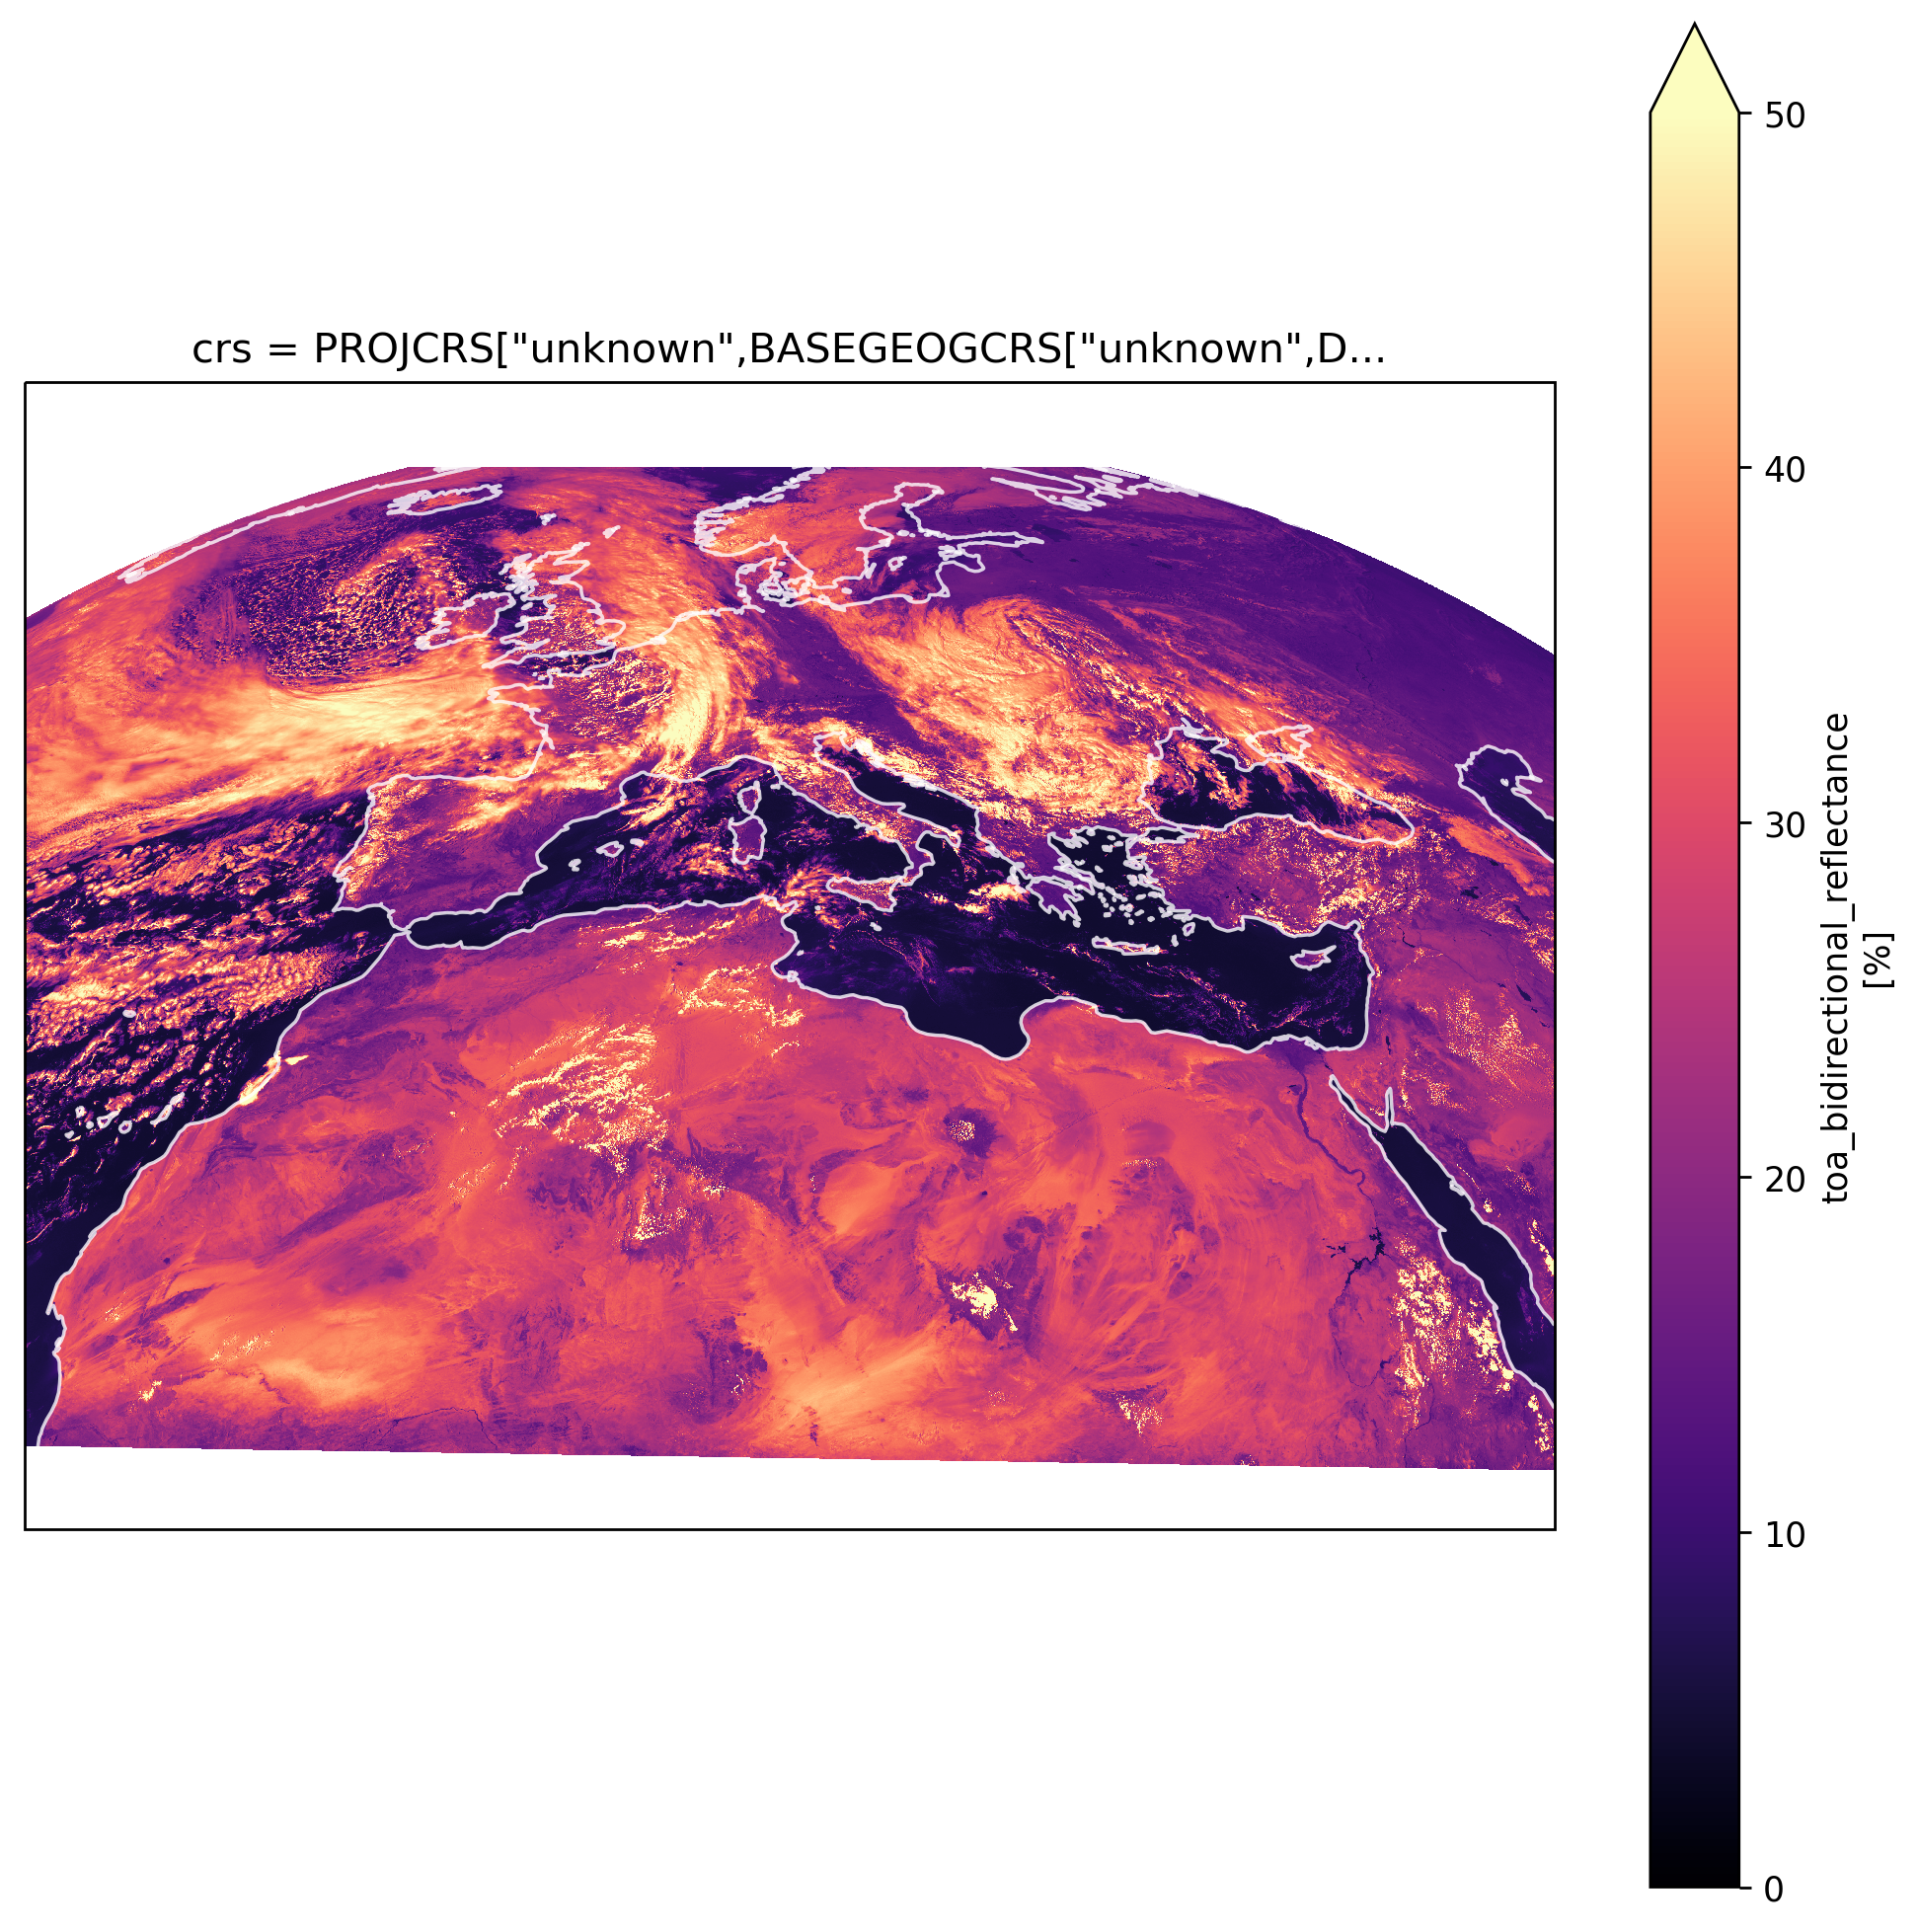

In [14]:
filename = df_metadata.loc[1, 'file_name']
native_fp = f'{data_dir}/{filename}.nat'

severi_area_def = reproj.get_seviri_area_def(native_fp)
seviri_crs = severi_area_def.to_cartopy_crs()

scene = reproj.load_scene(native_fp)
scene.load(['HRV'])

# Plotting
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=seviri_crs)

scene['HRV'].plot.imshow(ax=ax, cmap='magma', vmin=0, vmax=50)

ax.coastlines(resolution='50m', alpha=0.8, color='white')

In [7]:
%%capture --no-stdout
%%time

reprojector = reproj.Reprojector(new_coords_fp, new_grid_fp)
ds_reproj = reprojector.reproject(native_fp, reproj_library='pyinterp')

Wall time: 7.26 s


<ipython-input-8-4e8ea5206667>:3: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())


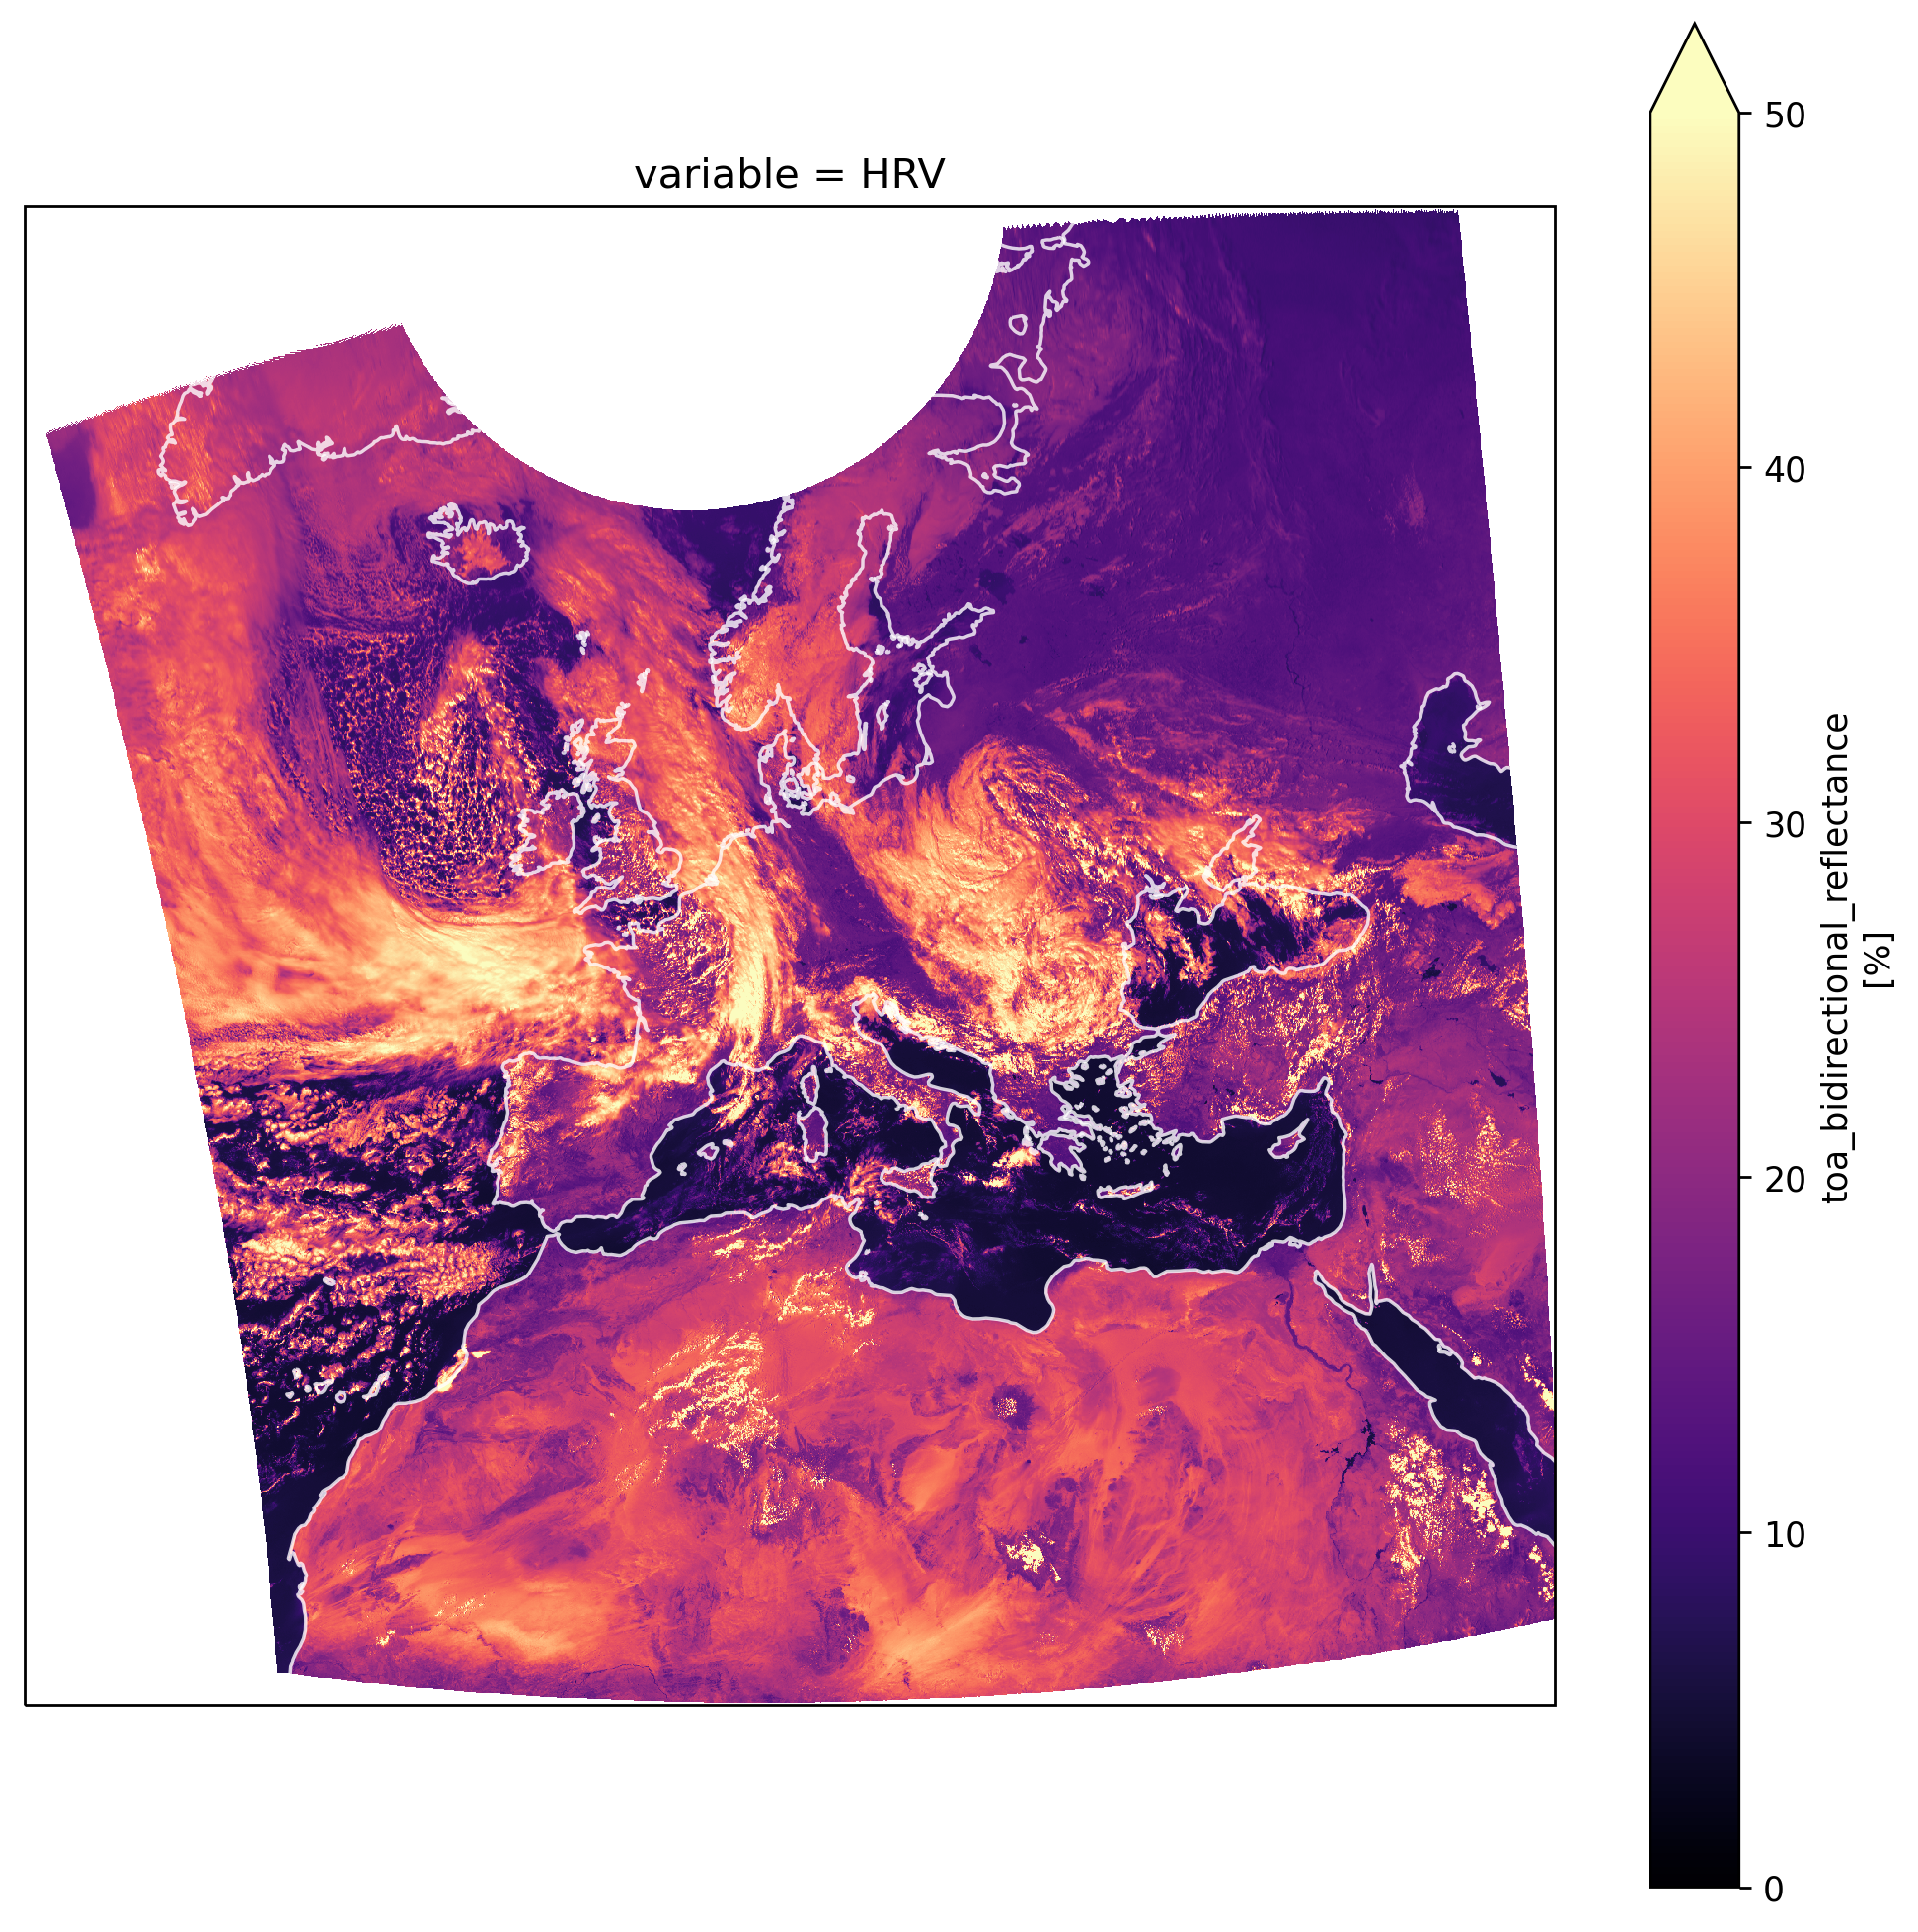

In [8]:
# Plotting
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

ds_reproj['stacked_eumetsat_data'].sel(variable='HRV').plot.imshow(ax=ax, cmap='magma', vmin=0, vmax=50)

ax.coastlines(resolution='50m', alpha=0.8, color='white')

In [13]:
compressor = io.Compressor()

da_compressed = compressor.compress(ds_reproj['stacked_eumetsat_data'])

da_compressed

<xarray.DataArray 'stacked_eumetsat_data' (y: 1831, x: 1870, variable: 12)>
array([[[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
...
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]]], dtype=int16)
Coordinates:
  * variable  (variable) object 'HRV' 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * x         (x) float64 4.388e+06 4.384e+06 4.38e+06 ... -3.084e+06 -3.088e+06
  * y         (y) float64 1.692e+06 1.696e+06 1.7e+06 ... 9.008e+06 9.012e+06

In [ ]:
# Need to make sure the attributes are being saved properly

In [21]:
def add_constant_coord_to_da(da, coord_name, coord_val):
    """
    Adds a new coordinate with a 
    constant value to the DataArray
    Parameters
    ----------
    da : xr.DataArray
        DataArrray which will have the new coords added to it
    coord_name : str
        Name for the new coordinate dimensions
    coord_val
        Value that will be assigned to the new coordinates
    Returns
    -------
    da : xr.DataArray
        DataArrray with the new coords added to it
    
    """
    
    da = da.assign_coords({coord_name:coord_val}).expand_dims(coord_name)
    
    return da

time = scene['HRV'].attrs['end_time']

add_constant_coord_to_da(da_compressed, 'time', time)

<xarray.DataArray 'stacked_eumetsat_data' (time: 1, y: 1831, x: 1870, variable: 12)>
array([[[[-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]],

        [[-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]],

        [[-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         ...,
...
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]],

        [[-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]],

        [[-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]]]], dtype=int16)
Coordinates:
  * variable  (variable) object 'HRV' 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * x         (x) float64 4.388e+06 4.384e+06 4.38e+06 ... -3.084e+06 -3.088e+06
  * y         (y) float64 1.692e+06 1.696e+06 1.7e+06 ... 9.008e+06 9.012e+06
  * time      (time) datetime64[ns] 2020-10-01T12:10:09.243313

In [16]:
io.save_da_to_zarr(da_compressed, out_zarr_bucket)

ValueError: ('time', 'x', 'y', 'variable') must be a permuted list of ('y', 'x', 'variable'), unless `...` is included